# KernelRidge Experiment with data

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
%matplotlib inline

In [2]:
def rbf_kernel(X1, X2, sigma=10):
    '''
    Returns the kernel matrix K(X1_i, X2_j): size (n1, n2)
    
    Input:
    ------
    X1: an (n1, p) matrix
    X2: an (n2, p) matrix
    '''
    # For loop with rbf_kernel_element works but is slow in python
    # Use matrix operations!
    X2_norm = np.sum(X2 ** 2, axis=-1)
    X1_norm = np.sum(X1 ** 2, axis=-1)
    gamma = 1 / (2 * sigma ** 2)
    K = np.exp(- gamma * (X1_norm[:, None] + X2_norm[None, :] - 2 * np.dot(X1, X2.T)))
    return K
def linear_kernel(X1, X2):
    '''
    Returns the kernel matrix K(X1_i, X2_j): size (n1, n2)
    where K is the linear kernel
    
    Input:
    ------
    X1: an (n1, p) matrix
    X2: an (n2, p) matrix
    '''
    return X1.dot(X2.T)

def polynomial_kernel(X1, X2, degree=3):
    '''
    Returns the kernel matrix K(X1_i, X2_j): size (n1, n2)
    where K is the polynomial kernel of degree `degree`
    
    Input:
    ------
    X1: an (n1, p) matrix
    X2: an (n2, p) matrix
    degree: int
    '''
    return (1 + linear_kernel(X1, X2))**degree

In [3]:
def sigma_from_median(X):
    '''
    Returns the median of ||Xi-Xj||
    
    Input
    -----
    X: (n, p) matrix
    '''
    pairwise_diff = X[:, :, None] - X[:, :, None].T
    pairwise_diff *= pairwise_diff
    euclidean_dist = np.sqrt(pairwise_diff.sum(axis=1))
    return np.median(euclidean_dist)


In [4]:
class KernelRidge():
    '''
    Kernel Ridge Regression
    
    Methods
    ----
    fit
    predict
    '''
    kernels_ = {
    'linear': linear_kernel,
    'polynomial': polynomial_kernel,
    'rbf': rbf_kernel,
    # 'custom_kernel': custom_kernel, # Your kernel
    }
    def __init__(self, sigma=None, lambd=0.1,kernel='rbf'):
        
        self.kernel = self.kernels_[kernel]
        self.sigma = sigma
        self.lambd = lambd

    def fit(self, X, y):
        n, p = X.shape
        assert (n == len(y))
    
        self.X_train = X
        
        # Compute default sigma from data
        if self.sigma is None:
            self.sigma = sigma_from_median(X)
        if self.kernel == 'rbf':
            A = self.kernel(X, X, sigma=self.sigma) + n * self.lambd * np.eye(n)
        else:
            A = self.kernel(X, X) + n * self.lambd * np.eye(n)
        
        ## self.alpha = (K + n lambda I)^-1 y
        # Solution to A x = y
        self.alpha = np.linalg.solve(A , y)

        return self
        
    def predict(self, X):
        # Prediction rule: 
        if self.kernel == 'rbf':
            K_x = self.kernel(X, self.X_train, sigma=self.sigma)
        else:
            K_x = self.kernel(X, self.X_train)
        return K_x.dot(self.alpha)

# My data

## Parameters

In [5]:
split = False
fine_tune = False

In [6]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split

X_train = pd.read_csv('Xtr_vectors.csv')
X_train.drop('Id', inplace=True, axis=1)
y_train = pd.read_csv('Ytr.csv')
y_train.drop('Id', inplace=True, axis=1)
X_test = pd.read_csv('Xte_vectors.csv')
iD = pd.DataFrame(X_test.Id)
X_test.drop('Id', inplace=True, axis=1)

In [7]:
X = np.array(X_train)
X = sklearn.preprocessing.scale(X)
y = np.array(y_train)
Xt = np.array(X_test)
Xt = sklearn.preprocessing.scale(Xt)

if split:
    # Scaling is important
    
    X, Xt, y, yt = train_test_split(X, y, test_size=0.33, random_state=42)

X.shape

(2000, 64)

In [8]:
model = KernelRidge(lambd=6.55128556859551e-05)
y_pred = model.fit(X, y).predict(Xt)
y_pred = (y_pred>0.5)
print(y_pred.shape)

(1000, 1)


# Fine-Tuning

In [9]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import classification_report

if fine_tune: 
    lam = 10**np.linspace(-5,3,50)
    score = 0
    for i in lam: 
        model = KernelRidge(lambd = i)
        model.fit(X,y)
        y_pred = model.predict(Xt)
        y_pred = y_pred >.5
        acc = accuracy_score(yt, y_pred)
        if (score < acc):
            best_lambd = i
            score = acc
    print('the best lambda is : ',best_lambd,' acc : ',score)

# Metric

In [10]:
# Prediction error
def error(ypred, ytrue):
    e = (ypred != ytrue).mean()
    return e

if split:
    print("Our model's performance:")
    print('Accuracy: {:.2%}'.format(accuracy_score(yt, y_pred)))
    print('AUC: {:.2%}'.format(roc_auc_score(yt, y_pred)))
    print('error: {:.2%}'.format(error(yt, y_pred)))    
    print(classification_report(yt, y_pred))

# Visualization

In [11]:
!pip install plotly

In [12]:
# Visualization
# References: https://scikit-learn.org/stable/auto_examples/svm/plot_iris.html
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(classifier, xx, yy, add_intercept=False, **params):
    """Plot the decision boundaries for a classifier.
    
    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    X = np.c_[xx.ravel(), yy.ravel()]
    if add_intercept:
        X = add_column_ones(X)
    Z = classifier.predict(X)
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    return out

def plot_decision_function(classifier, X_train, y_train, title='', add_intercept=False):
    fig = plt.figure(figsize=(8,7))
    X0, X1 = X_train[:, 0], X_train[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    plot_contours(classifier, xx, yy, cmap=plt.cm.GnBu, alpha=0.5, add_intercept=add_intercept)
    plt.scatter(X0, X1, c=y_train, cmap=plt.cm.GnBu, s=20, edgecolors='k')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.title(title)
    plt.show()

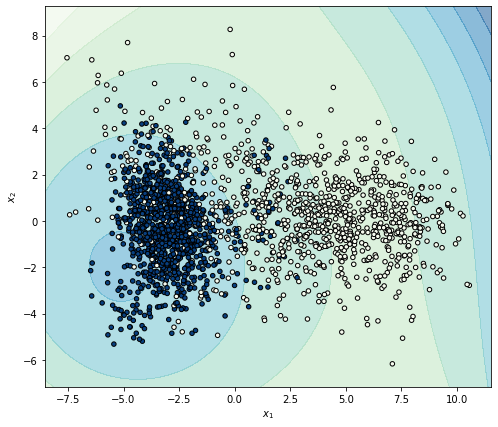

In [13]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X)
clf = KernelRidge(lambd=6.55128556859551e-05, kernel = 'polynomial')
clf.fit(X_pca, y)
plot_decision_function(clf, X_pca, y, title='', add_intercept=False)

# Submission

In [14]:
import pandas as pd
if not split:
    #data frame for prediction
    pred = pd.DataFrame(y_pred, columns = ["Covid"])
    #stack the data frame for id and pred
    result = pd.DataFrame(np.hstack([iD,pred]), columns = ["ID", "Covid"])
    result.to_csv("Yte.csv",index=False)